## Try to max out score with ensemble learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [5]:
train_data = pd.read_csv("Data/train.csv")

In [6]:
train_data.shape

(42000, 785)

In [7]:
target = train_data['label']
train_vars = train_data.drop(['label'],axis=1)

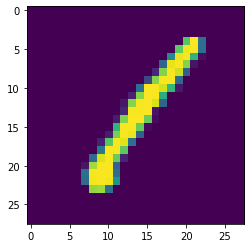

In [8]:
plt.imshow(np.asarray(train_vars.iloc[0]).reshape((28,28)))

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [38]:
X = train_vars
y = target

X_train, X_test, y_train, y_test = train_test_split(X/255,y,test_size = 0.33)

In [11]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

/home/ben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
print('Accuracy on test set: {}'.format(rf.score(X_test,y_test)))

Accuracy on test set: 0.9323953823953824


In [13]:
from sklearn import svm
s = svm.SVC(gamma = 'scale')
s.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
y_pred = s.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Accuracy: {}'.format(acc))

Accuracy: 0.9741702741702741


In [45]:
test_data = pd.read_csv('Data/test.csv')

In [ ]:
test_data.shape

In [ ]:
test_data.head()

In [46]:
svm_predictions = s.predict(test_data/255)

KeyboardInterrupt: 

In [ ]:
svm_predictions

In [35]:
ImageId = np.arange(1,test_data.shape[0]+1,1)

In [27]:
sub = pd.DataFrame({'ImageId':ImageId, 'Label':svm_predictions})

In [29]:
sub.to_csv('svm_submission.csv',index=False)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

k = KNeighborsClassifier()
k.fit(X_train,y_train)
y_pred = k.predict(X_test)

acc = accuracy_score(y_test,y_pred)
print('Accuracy: {}'.format(acc))

Accuracy: 0.9627705627705627


In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train,y_train)

y_pred = xg.predict(X_test)

acc = accuracy_score(y_test,y_pred)
print('Accuracy: {}'.format(acc))

In [53]:
from tensorflow.keras import layers, models
from tensorflow import keras

inputs = keras.Input(shape=(784,))
x= layers.Dense(64,activation='relu')(inputs)
x= layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)

d_model = keras.Model(inputs=inputs,outputs=outputs)

In [54]:
d_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.2)

In [55]:
d_model.fit(X_train,y_train,
          epochs=50,validation_split=0.2,
         batch_size=128, shuffle=True,callbacks =[lr_reduction,es])

Train on 22512 samples, validate on 5628 samples
Epoch 1/50
22512/22512 [==============================] - 1s 41us/sample - loss: 0.6378 - accuracy: 0.8186 - val_loss: 0.3196 - val_accuracy: 0.9104
Epoch 2/50
22512/22512 [==============================] - 1s 35us/sample - loss: 0.2453 - accuracy: 0.9297 - val_loss: 0.2444 - val_accuracy: 0.9295
Epoch 3/50
22512/22512 [==============================] - 1s 36us/sample - loss: 0.1878 - accuracy: 0.9464 - val_loss: 0.2052 - val_accuracy: 0.9408
Epoch 4/50
22512/22512 [==============================] - 1s 35us/sample - loss: 0.1538 - accuracy: 0.9548 - val_loss: 0.1890 - val_accuracy: 0.9444
Epoch 5/50
22512/22512 [==============================] - 1s 36us/sample - loss: 0.1278 - accuracy: 0.9638 - val_loss: 0.1759 - val_accuracy: 0.9474
Epoch 6/50
22512/22512 [==============================] - 1s 35us/sample - loss: 0.1105 - accuracy: 0.9679 - val_loss: 0.1679 - val_accuracy: 0.9510
Epoch 7/50
22512/22512 [==============================] -

In [63]:
dense_predictions = d_model.predict(test_data/255)

In [64]:
dense_predictions = np.argmax(dense_predictions,axis=1)

In [ ]:
svm_predictions = s.predict(test_data/255)
xg_predictions = xg.predict(test_data/255)
rf_predictions = rf.predict(test_data/255)
k_predictions = k.predict(test_data/255)

### Now time for a CNN

In [20]:
X_train = X_train.values.reshape(X_train.shape[0],28,28,1)
X_test = X_test.values.reshape(X_test.shape[0],28,28,1)

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(64, (4,4),activation='relu',input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (7,7),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (2,2),activation='relu'))

In [23]:
model.add(layers.Flatten())
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          100384    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4

In [25]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [26]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.2)

In [27]:
model.fit(X_train,np.array(y_train),
          epochs=50,validation_split=0.2,
         batch_size=128, shuffle=True,callbacks =[lr_reduction,es])

Train on 22512 samples, validate on 5628 samples
Epoch 1/50
22512/22512 [==============================] - 14s 616us/sample - loss: 0.5532 - accuracy: 0.8264 - val_loss: 0.2304 - val_accuracy: 0.9286
Epoch 2/50
22512/22512 [==============================] - 13s 575us/sample - loss: 0.1457 - accuracy: 0.9566 - val_loss: 0.1392 - val_accuracy: 0.9588
Epoch 3/50
22512/22512 [==============================] - 13s 568us/sample - loss: 0.0950 - accuracy: 0.9715 - val_loss: 0.1059 - val_accuracy: 0.9671
Epoch 4/50
22512/22512 [==============================] - 13s 565us/sample - loss: 0.0693 - accuracy: 0.9788 - val_loss: 0.0880 - val_accuracy: 0.9748
Epoch 5/50
22512/22512 [==============================] - 11s 509us/sample - loss: 0.0530 - accuracy: 0.9832 - val_loss: 0.0789 - val_accuracy: 0.9757
Epoch 6/50
22512/22512 [==============================] - 12s 518us/sample - loss: 0.0449 - accuracy: 0.9861 - val_loss: 0.0744 - val_accuracy: 0.9781
Epoch 7/50
22512/22512 [=====================

In [28]:
model.evaluate(X_test,np.array(y_test))

13860/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05885160547140375, 0.98621935]

In [29]:
NN_test = test_data/255

In [30]:
NN_test = NN_test.values.reshape(NN_test.shape[0],28,28,1)

In [33]:
cnn_predictions = model.predict_classes(NN_test)

In [36]:
sub = pd.DataFrame({'ImageId':ImageId, 'Label':cnn_predictions})

In [37]:
sub.to_csv("CNN_es_lrr.csv",index=False)

In [82]:
sub = pd.DataFrame({'CNN':cnn_predictions,'SVM':svm_predictions,'XG':xg_predictions, 'RF':rf_predictions,
                   'K':k_predictions, 'DNN':dense_predictions})

In [83]:
sub

,CNN,SVM,XG,RF,K,DNN
0,2,2,2,2,2,2
1,0,0,0,0,0,0
2,9,9,9,9,9,9
3,9,9,7,4,4,2
4,3,3,2,3,3,3
...,...,...,...,...,...,...
27995,9,9,9,9,9,9
27996,7,7,7,7,7,7
27997,3,3,3,3,3,3
27998,9,9,9,9,9,9


In [92]:
sub = sub.mode(axis=1)[0].astype('int32')

In [94]:
sub_ens = pd.DataFrame({'ImageId':ImageId, 'Label':sub})

In [96]:
sub_ens.to_csv('ensemble_preds.csv',index=False)